In [1]:
# --- CELL 0: ENVIRONMENT SETUP, DRIVE, AND DEPENDENCIES ---
import os
import torch
import random
import numpy as np
from google.colab import drive

# 1. Mount Google Drive (with existence check)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted.")

# 2. Silent installation of PyTorch Geometric
!pip install -q torch-geometric

# 3. Import necessary libraries
import torch_geometric
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

# 4. Device Configuration (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 5. Reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything()

print(f"Environment ready on: {device}")
print(f"PyG version: {torch_geometric.__version__}")

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.9 MB/s eta 0:00:00
Environment ready on: cuda
PyG version: 2.7.0


# Dataset and Dataloader definition

In [2]:
# --- CELL 1: DATASET DEFINITION AND SYNCHRONIZED SPLIT LOADING ---
import os
import torch
import json
import numpy as np
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

# --- 1. DATASET CLASS DEFINITION ---
class TaskGraphDataset(Dataset):
    def __init__(self, root_dir):
        super().__init__()
        self.root_dir = root_dir
        if not os.path.exists(root_dir):
            raise FileNotFoundError(f"The directory {root_dir} does not exist!")

        # Filter for .pt files only
        self.file_list = sorted([f for f in os.listdir(root_dir) if f.endswith('.pt')])

    def len(self):
        return len(self.file_list)

    def get(self, idx):
        path = os.path.join(self.root_dir, self.file_list[idx])
        raw_data = torch.load(path, weights_only=False)

        # Late Fusion
        x = torch.cat([raw_data['x_text'], raw_data['x_video']], dim=-1)

        data = Data(
            x=x,
            edge_index=raw_data['edge_index'],
            y=raw_data['y'].float(),
            vid_id=raw_data['vid_id']
        )
        return data

# --- 2. PATH CONFIGURATION ---
GNN_DATA_DIR = '/content/drive/MyDrive/AML_Project/Extension/step_3_task_graph/gnn_ready_data'
SPLIT_JSON_PATH = '/content/drive/MyDrive/AML_Project/Extension/step_2_baseline/models_gnn_split_bsv2/master_split_ids.json'

full_dataset = TaskGraphDataset(GNN_DATA_DIR)

# --- 3. LOADING SPLIT JSON ---
print(f"Loading Split from: {SPLIT_JSON_PATH}")
if not os.path.exists(SPLIT_JSON_PATH):
    raise FileNotFoundError("Split JSON not found. Please run the Baseline notebook first!")

with open(SPLIT_JSON_PATH, 'r') as f:
    split_ids = json.load(f)

# Fast lookup sets
train_ids_set = set(split_ids['train'])
val_ids_set = set(split_ids['val'])
test_ids_set = set(split_ids['test'])

print(f"Target IDs -> Train: {len(train_ids_set)} | Val: {len(val_ids_set)} | Test: {len(test_ids_set)}")

# --- 4. FILE MAPPING ---
print("\nMapping File GNN -> ID JSON...")
train_indices, val_indices, test_indices = [], [], []

for idx, filename in enumerate(full_dataset.file_list):
    # Filename example: "gnn_ready_1_7.pt"
    # 1. Remove .pt extension -> "gnn_ready_1_7"
    temp = filename.replace('.pt', '')
    # 2. Remove prefix gnn_ready_ -> "1_7"
    vid_id = temp.replace('gnn_ready_', '')

    if vid_id in train_ids_set:
        train_indices.append(idx)
    elif vid_id in val_ids_set:
        val_indices.append(idx)
    elif vid_id in test_ids_set:
        test_indices.append(idx)

# Final statistics
n_found = len(train_indices) + len(val_indices) + len(test_indices)
print(f"Found {n_found} matching files out of {len(full_dataset.file_list)} total files")
print(f"   - Train: {len(train_indices)}")
print(f"   - Val:   {len(val_indices)}")
print(f"   - Test:  {len(test_indices)}")

if len(train_indices) == 0:
    # Emergency debug print
    print(f"DEBUG ERROR: File '{full_dataset.file_list[0]}' -> Extracted ID '{full_dataset.file_list[0].replace('.pt','').replace('gnn_ready_','')}' vs Expected ID '{list(train_ids_set)[0]}'")
    raise ValueError("No files mapped! Please check the naming logic")

# --- 5. DATALOADER CREATION ---
train_dataset = Subset(full_dataset, train_indices)
val_dataset   = Subset(full_dataset, val_indices)
test_dataset  = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("\nDATALOADERS READY")

Loading Split from: /content/drive/MyDrive/AML_Project/Extension/step_2_baseline/models_gnn_split_bsv2/master_split_ids.json
Target IDs -> Train: 268 | Val: 57 | Test: 59

Mapping File GNN -> ID JSON...
Found 384 matching files out of 384 total files
   - Train: 268
   - Val:   57
   - Test:  59

DATALOADERS READY


# GNN

In [ ]:
# --- CELL 2: GRAPH SAGE ARCHITECTURE (Hybrid Pooling) ---
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import SAGEConv, global_max_pool, global_mean_pool

class GNNClassifier(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate=0.5):
        """
        GraphSAGE with HYBRID POOLING.
        We concatenate MaxPool (to detect error peaks) and MeanPool (for global context).
        """
        super(GNNClassifier, self).__init__()
        torch.manual_seed(42)

        # 1. Input Layer
        self.conv1 = SAGEConv(512, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)

        # 2. Hidden Layer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)

        # 3. Output Layer
        # * 2 because we concatenate Mean and Max pooling (hidden_dim + hidden_dim)
        self.lin = Linear(hidden_channels * 2, 1)

        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index, batch):
        # --- Block 1 ---
        x = self.conv1(x, edge_index).relu()
        x = self.bn1(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # --- Block 2 ---
        x = self.conv2(x, edge_index).relu()
        x = self.bn2(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # --- Hybrid Pooling ---
        # Capture both local anomalies (Max) and global context (Mean)
        x_max = global_max_pool(x, batch)
        x_mean = global_mean_pool(x, batch)

        # Concatenation
        x = torch.cat([x_max, x_mean], dim=1)

        # --- Classification ---
        x = self.lin(x)
        return x

# Training and test

In [ ]:
# --- CELL 3: TRAINING AND EVALUATION LOGIC ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def train(model, loader, optimizer, criterion):
    """Executes one training epoch."""
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def get_predictions(model, loader):
    """Extracts raw probabilities to allow for optimal threshold calculation."""
    model.eval()
    probs, labels = [], []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        probs.extend(torch.sigmoid(out).view(-1).cpu().tolist())
        labels.extend(data.y.cpu().tolist())
    return np.array(probs), np.array(labels)

def test(model, loader, threshold=0.5):
    """
    Retrieves predictions and calculates the 5 fundamental metrics.
    """
    probs, labels = get_predictions(model, loader)
    preds = (probs > threshold).astype(float)

    acc = (preds == labels).mean()
    f1 = f1_score(labels, preds, zero_division=0)
    prec = precision_score(labels, preds, zero_division=0)
    rec = recall_score(labels, preds, zero_division=0)
    cm = confusion_matrix(labels, preds)

    return acc, f1, prec, rec, cm

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Creates a chart for the final report."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['OK', 'Error'], yticklabels=['OK', 'Error'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

✅ Training su device: cuda
🚀 Avvio Training GNN Standard...
Epoch  | Loss     | Val Acc  | Val F1   | Status
------------------------------------------------------------
001    | 0.8323   | 0.5263   | 0.5714   | ⭐ Best
002    | 0.6266   | 0.6140   | 0.6667   | ⭐ Best
003    | 0.5647   | 0.5965   | 0.6462   | 
004    | 0.5240   | 0.6491   | 0.6970   | ⭐ Best
005    | 0.4870   | 0.6316   | 0.6769   | 
006    | 0.3898   | 0.5965   | 0.6230   | 
007    | 0.3837   | 0.6667   | 0.6885   | 
008    | 0.3885   | 0.7193   | 0.7333   | ⭐ Best
009    | 0.3394   | 0.6667   | 0.6885   | 
010    | 0.3373   | 0.6316   | 0.6557   | 
011    | 0.3272   | 0.6140   | 0.6207   | 
012    | 0.2508   | 0.6491   | 0.6875   | 
013    | 0.1888   | 0.6491   | 0.6875   | 
014    | 0.1706   | 0.6842   | 0.7000   | 
015    | 0.1883   | 0.6667   | 0.6780   | 
016    | 0.1831   | 0.6140   | 0.6207   | 
017    | 0.1161   | 0.5965   | 0.5818   | 
018    | 0.1520   | 0.6140   | 0.6071   | 
019    | 0.1483   | 0.6667   | 0

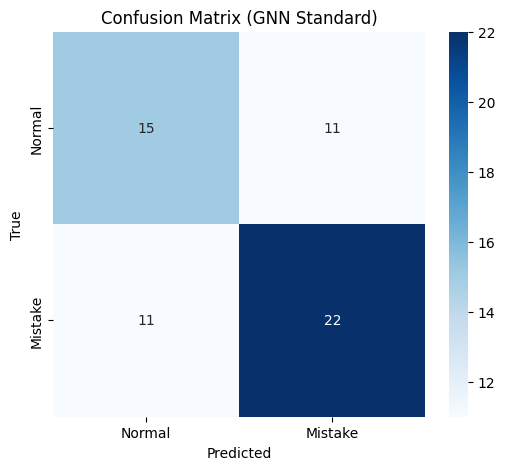

In [ ]:
# --- CELL 4: TRAINING ---
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

hparams = {
    'hidden_dim': 128,
    'lr': 0.001,           # Standard learning rate
    'weight_decay': 1e-4,  # Standard regularization (not aggressive)
    'epochs': 100,
    'patience': 15,
    'dropout': 0.5         # Balanced dropout
}

# Model & Optimizer
model = GNNClassifier(hidden_channels=hparams['hidden_dim'], dropout_rate=hparams['dropout']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'], weight_decay=hparams['weight_decay'])

# Standard Loss
criterion = torch.nn.BCEWithLogitsLoss()

# Training function per epoch
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out.view(-1), batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            probs = torch.sigmoid(out.view(-1))
            preds.extend((probs > 0.5).float().cpu().numpy()) # Soglia fissa 0.5
            targets.extend(batch.y.cpu().numpy())

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, zero_division=0)
    return acc, f1, targets, preds

# --- TRAINING LOOP ---
print(f"Starting Standard GNN Training...")
print(f"{'Epoch':<6} | {'Loss':<8} | {'Val Acc':<8} | {'Val F1':<8} | {'Status'}")
print("-" * 60)

best_val_f1 = 0
patience_counter = 0
history = {'loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(1, hparams['epochs'] + 1):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_f1, _, _ = evaluate(model, val_loader)

    history['loss'].append(loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    status = ""
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_gnn_model.pth')
        status = "Best"
    else:
        patience_counter += 1

    print(f"{epoch:03d}    | {loss:.4f}   | {val_acc:.4f}   | {val_f1:.4f}   | {status}")

    if patience_counter >= hparams['patience']:
        print(f"\nEarly Stopping at epoch {epoch}")
        break

# --- FINAL EVALUATION ON TEST SET ---
print("\nFINAL EVALUATION (Test Set)...")
model.load_state_dict(torch.load('best_gnn_model.pth')) # Load best weights
test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp) if (tn+fp) > 0 else 0
recall = tp / (tp+fn) if (tp+fn) > 0 else 0

print("-" * 50)
print(f"   GNN RESULTS (Threshold 0.5):")
print(f"   Accuracy:    {test_acc:.4f}")
print(f"   F1-Score:    {test_f1:.4f}")
print(f"   Recall:      {recall:.4f}")
print(f"   Specif:      {specificity:.4f}")
print("-" * 50)

# Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Mistake'], yticklabels=['Normal', 'Mistake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (GNN Standard)')
plt.show()

Verifying GNN Split consistency...
   Scanning Train (268 items)...
   Scanning Val (57 items)...
   Scanning Test (59 items)...

  GNN SPLIT STATISTICS:
   TRAIN: Total 268 | Normal: 113 | Mistake: 155
   VAL:   Total 57  | Normal: 25  | Mistake: 32
   TEST:  Total 59  | Normal: 26  | Mistake: 33


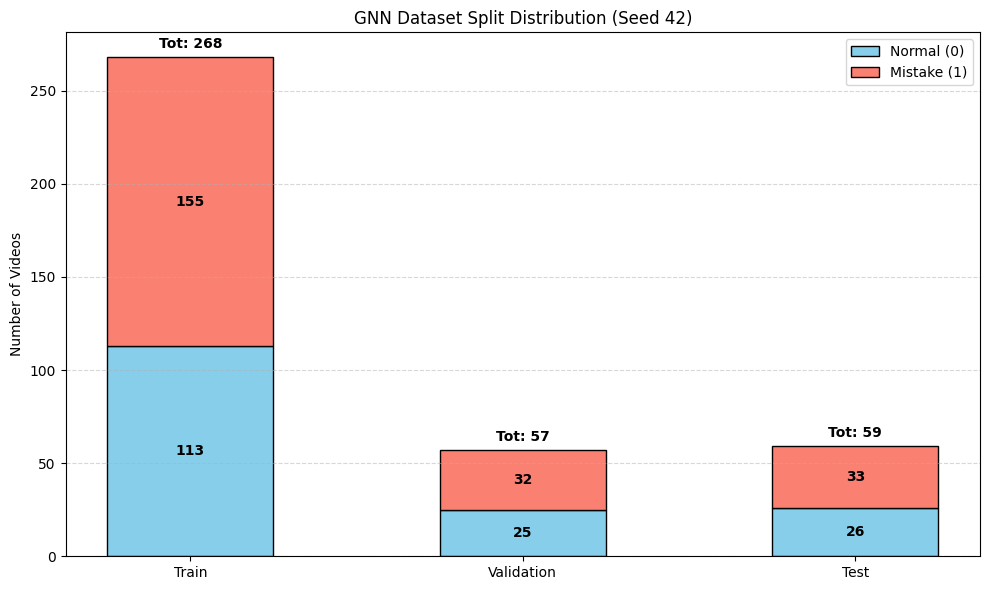

In [4]:
# --- Dataset VERIFICATION CELL ---
import matplotlib.pyplot as plt
import numpy as np

def verify_gnn_split_consistency(train_ds, val_ds, test_ds):
    print("Verifying GNN Split consistency...")

    def get_counts(dataset, name):
        print(f"   Scanning {name} ({len(dataset)} items)...")
        normal = 0
        mistake = 0
        # Iterate through the entire dataset (may take a few seconds to load files)
        for i in range(len(dataset)):
            data = dataset[i]
            label = int(data.y.item()) # Assuming data.y is 0 or 1
            if label == 0:
                normal += 1
            else:
                mistake += 1
        return normal, mistake

    # Calculate statistics
    tr_n, tr_m = get_counts(train_ds, "Train")
    val_n, val_m = get_counts(val_ds, "Val")
    te_n, te_m = get_counts(test_ds, "Test")

    # Print exact numbers
    print("\n  GNN SPLIT STATISTICS:")
    print(f"   TRAIN: Total {len(train_ds)} | Normal: {tr_n} | Mistake: {tr_m}")
    print(f"   VAL:   Total {len(val_ds)}  | Normal: {val_n}  | Mistake: {val_m}")
    print(f"   TEST:  Total {len(test_ds)}  | Normal: {te_n}  | Mistake: {te_m}")

    # Plot Chart
    splits = ['Train', 'Validation', 'Test']
    normals = [tr_n, val_n, te_n]
    mistakes = [tr_m, val_m, te_m]

    x = np.arange(len(splits))
    width = 0.5

    plt.figure(figsize=(10, 6))
    p1 = plt.bar(x, normals, width, label='Normal (0)', color='skyblue', edgecolor='black')
    p2 = plt.bar(x, mistakes, width, bottom=normals, label='Mistake (1)', color='salmon', edgecolor='black')

    plt.ylabel('Number of Videos')
    plt.title('GNN Dataset Split Distribution (Seed 42)')
    plt.xticks(x, splits)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Labels on blocks
    for i in range(len(splits)):
        # Normal label
        if normals[i] > 0:
            plt.text(i, normals[i]/2, str(normals[i]), ha='center', va='center', fontweight='bold')
        # Mistake label
        if mistakes[i] > 0:
            plt.text(i, normals[i] + mistakes[i]/2, str(mistakes[i]), ha='center', va='center', fontweight='bold')
        # Total label
        plt.text(i, normals[i] + mistakes[i] + 5, f"Tot: {normals[i]+mistakes[i]}", ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# EXECUTION
# Ensure that 'train_dataset', 'val_dataset', 'test_dataset' variables are defined
if 'train_dataset' in locals():
    verify_gnn_split_consistency(train_dataset, val_dataset, test_dataset)
else:
    print("Error: 'train_dataset' or 'val_dataset' variables not found in memory.")